**Simple MultiAgent**

In [ ]:
from typing import Annotated, TypedDict, List, Literal
from langgraph.graph import StateGraph, START, END, add_messages, MessagesState
from langgraph.prebuilt import ToolNode,  tools_condition
from langchain.agents import create_agent
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
import os
from dotenv import load_dotenv


In [ ]:
,  tools_condition
from langchain.agents import create_agent
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
import os
from dotenv import load_dotenv


In [2]:
load_dotenv()
os.environ["GROQ_API_KEY"]= os.getenv("GROQ_API_KEY")


In [3]:
##Define the  State

class AgentState(MessagesState):
    next_agent:str #which agent should go next

In [4]:
@tool
def search_web(query: str)-> str:
    """Search teh web for information."""
    search = TavilySearchResults(max_results = 3)
    results = search.invoke(query)
    return str(results)

@tool
def write_summary(content:str) -> str:
    """Write a summary of the provided content."""
    #Simple summary generation
    summary = f"Summary of finding:\n\n{content[:500]}..."

In [5]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000026D2B9FE060>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000026D2BD251F0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
def researcher_agent(state: AgentState):
    """Researcher agent that searches for information"""
    messages = state['messages']

    #Add system message for context

    system_msg = SystemMessage(content="You are a research assistant. Use the search_web tool to fing the infromation about the user's request.")
    researcher_llm = llm.bind_tools([search_web])

    response = researcher_llm.invoke([system_msg]+ messages)

    #Return response an droute to writer
    return {
        "messages": [response],
        "next_agent": "writer"
    }

In [29]:
def writer_agent(state:AgentState):
    """Writer agent that creates summarier"""

    messages = state['messages']

    system_msg = SystemMessage(content="You are a tenchnical writer. Review the converstaion and create  a clear, concise summary of the findings.")
    
    #wihtout tool
    
    #writer_llm = llm.bind_tools([write_summary])
    response = llm.invoke([system_msg]+ messages)

    return {
        "messages": [response],
        "next_agent" : "end"
    }

In [30]:
#Tool executor node
def execut_tools(state: AgentState):
    """Execture any pending tool calls"""
    messages = state['messages']
    last_message = messages[-1]

    #check if there are tool calls to execute

    if hasattr(last_message ,"tool_calls") and last_message.tool_calls:
        #Create tool node and execute
        tool_node = ToolNode([search_web,write_summary])
        response = tool_node.invoke(state)
        return response
    
    #no tools to execute
    return state


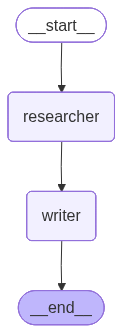

In [34]:
#Build graph
workflow = StateGraph (MessagesState)

#Add nodes
workflow.add_node("researcher",researcher_agent)
workflow.add_node("writer",writer_agent)

#Define flow
workflow.set_entry_point("researcher")
workflow.add_edge("researcher","writer")
workflow.add_edge("writer", END)

final_workflow = workflow.compile()
final_workflow



In [32]:
response = final_workflow.invoke({"messages":"Research about the usecase of agentic ai in business"})

In [24]:
response["messages"]

[HumanMessage(content='Research about the usecase of agentic ai in business', additional_kwargs={}, response_metadata={}, id='4c90223f-c1c2-45bc-af57-075a838f0007'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '6htwpvh53', 'function': {'arguments': '{"query":"agentic ai in business use case"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 244, 'total_tokens': 264, 'completion_time': 0.035119694, 'prompt_time': 0.013357155, 'queue_time': 0.035122267, 'total_time': 0.048476849}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_020e283281', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--58cf32cb-103b-454c-9997-f6366162d537-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'agentic ai in business use case'}, 'id': '6htwpvh53', 'type': 'tool_call'}], usage_metadata={'input_tokens': 244, 'output_tokens': 

**Supervise Multi AI Agent Architecture**

In [33]:
from typing import TypedDict , Annotated, List, Literal, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
import random
from datetime import datetime

In [36]:
#=================================================
# State Definition
#==================================================

# class SupervisorState(MessagesState):
#     """State for the supervisor multi-agent system"""
#     current_agent: str = ""
#     task_assignments: Dict[str,List[str]] = {} #Track what each agent should do
#     agent_outputs: Dict[str, Any] = {} #Store outputs from each agent
#     workflow_stage: str = "initial" #track workflow progress
#     iteration_count: int = 0
#     max_iterations: int = 10
#     final_output: str = ""


class SupervisorState(MessagesState):
    """State for the multi-agent system"""
    next_agent: str = ""
    research_data: str = ""
    analysis: str = ""
    final_report: str = ""
    task_complete: bool = False
    current_task: str = ""




In [37]:
# ===================================
# Supervisor with Groq LLM
# ===================================
from langchain_core.prompts import ChatPromptTemplate
def create_supervisor_chain():
    """Creates the supervisor decision chain"""
    
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor managing a team of agents:
        
1. Researcher - Gathers information and data
2. Analyst - Analyzes data and provides insights  
3. Writer - Creates reports and summaries

Based on the current state and conversation, decide which agent should work next.
If the task is complete, respond with 'DONE'.

Current state:
- Has research data: {has_research}
- Has analysis: {has_analysis}
- Has report: {has_report}

Respond with ONLY the agent name (researcher/analyst/writer) or 'DONE'.
"""),
        ("human", "{task}")
    ])
    
    return supervisor_prompt | llm

In [38]:
def supervisor_agent(state: SupervisorState) -> Dict:
    """Supervisor decides next agent using Groq LLM"""
    
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"
    
    # Check what's been completed
    has_research = bool(state.get("research_data", ""))
    has_analysis = bool(state.get("analysis", ""))
    has_report = bool(state.get("final_report", ""))
    
    # Get LLM decision
    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_analysis": has_analysis,
        "has_report": has_report
    })
    
    # Parse decision
    decision_text = decision.content.strip().lower()
    print(decision_text)
    
    # Determine next agent
    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: All tasks complete! Great work team."
    elif "researcher" in decision_text or not has_research:
        next_agent = "researcher"
        supervisor_msg = "📋 Supervisor: Let's start with research. Assigning to Researcher..."
    elif "analyst" in decision_text or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "📋 Supervisor: Research done. Time for analysis. Assigning to Analyst..."
    elif "writer" in decision_text or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "📋 Supervisor: Analysis complete. Let's create the report. Assigning to Writer..."
    else:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: Task seems complete."
    
    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }

In [39]:
# ===================================
# Agent 1: Researcher (using Groq)
# ===================================

def researcher_agent(state: SupervisorState) -> Dict:
    """Researcher uses Groq to gather information"""
    
    task = state.get("current_task", "research topic")
    
    # Create research prompt
    research_prompt = f"""As a research specialist, provide comprehensive information about: {task}

    Include:
    1. Key facts and background
    2. Current trends or developments
    3. Important statistics or data points
    4. Notable examples or case studies
    
    Be concise but thorough."""
    
    # Get research from LLM
    research_response = llm.invoke([HumanMessage(content=research_prompt)])
    research_data = research_response.content
    
    # Create agent message
    agent_message = f"🔍 Researcher: I've completed the research on '{task}'.\n\nKey findings:\n{research_data[:500]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "research_data": research_data,
        "next_agent": "supervisor"
    }

In [40]:
# ===================================
# Agent 2: Analyst (using Groq)
# ===================================

def analyst_agent(state: SupervisorState) -> Dict:
    """Analyst uses Groq to analyze the research"""
    
    research_data = state.get("research_data", "")
    task = state.get("current_task", "")
    
    # Create analysis prompt
    analysis_prompt = f"""As a data analyst, analyze this research data and provide insights:

Research Data:
{research_data}

Provide:
1. Key insights and patterns
2. Strategic implications
3. Risks and opportunities
4. Recommendations

Focus on actionable insights related to: {task}"""
    
    # Get analysis from LLM
    analysis_response = llm.invoke([HumanMessage(content=analysis_prompt)])
    analysis = analysis_response.content
    
    # Create agent message
    agent_message = f"📊 Analyst: I've completed the analysis.\n\nTop insights:\n{analysis[:400]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "analysis": analysis,
        "next_agent": "supervisor"
    }

In [41]:
# ===================================
# Agent 3: Writer (using Groq)
# ===================================

def writer_agent(state: SupervisorState) -> Dict:
    """Writer uses Groq to create final report"""
    
    research_data = state.get("research_data", "")
    analysis = state.get("analysis", "")
    task = state.get("current_task", "")
    
    # Create writing prompt
    writing_prompt = f"""As a professional writer, create an executive report based on:

Task: {task}

Research Findings:
{research_data[:1000]}

Analysis:
{analysis[:1000]}

Create a well-structured report with:
1. Executive Summary
2. Key Findings  
3. Analysis & Insights
4. Recommendations
5. Conclusion

Keep it professional and concise."""
    
    # Get report from LLM
    report_response = llm.invoke([HumanMessage(content=writing_prompt)])
    report = report_response.content
    
    # Create final formatted report
    final_report = f"""
📄 FINAL REPORT
{'='*50}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Topic: {task}
{'='*50}

{report}

{'='*50}
Report compiled by Multi-Agent AI System powered by Groq
"""
    
    return {
        "messages": [AIMessage(content=f"✍️ Writer: Report complete! See below for the full document.")],
        "final_report": final_report,
        "next_agent": "supervisor",
        "task_complete": True
    }

In [42]:
# ===================================
# Router Function
# ===================================

def router(state: SupervisorState) -> Literal["supervisor", "researcher", "analyst", "writer", "__end__"]:
    """Routes to next agent based on state"""
    
    next_agent = state.get("next_agent", "supervisor")
    
    if next_agent == "end" or state.get("task_complete", False):
        return END
        
    if next_agent in ["supervisor", "researcher", "analyst", "writer"]:
        return next_agent
        
    return "supervisor"

In [43]:
# ===================================
# Router Function
# ===================================

def router(state: SupervisorState) -> Literal["supervisor", "researcher", "analyst", "writer", "__end__"]:
    """Routes to next agent based on state"""
    
    next_agent = state.get("next_agent", "supervisor")
    
    if next_agent == "end" or state.get("task_complete", False):
        return END
        
    if next_agent in ["supervisor", "researcher", "analyst", "writer"]:
        return next_agent
        
    return "supervisor"

In [44]:
# Create workflow
workflow = StateGraph(SupervisorState)

# Add nodes
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("researcher", researcher_agent)
workflow.add_node("analyst", analyst_agent)
workflow.add_node("writer", writer_agent)

# Set entry point
workflow.set_entry_point("supervisor")

# Add routing
for node in ["supervisor", "researcher", "analyst", "writer"]:
    workflow.add_conditional_edges(
        node,
        router,
        {
            "supervisor": "supervisor",
            "researcher": "researcher",
            "analyst": "analyst",
            "writer": "writer",
            END: END
        }
    )

graph=workflow.compile()

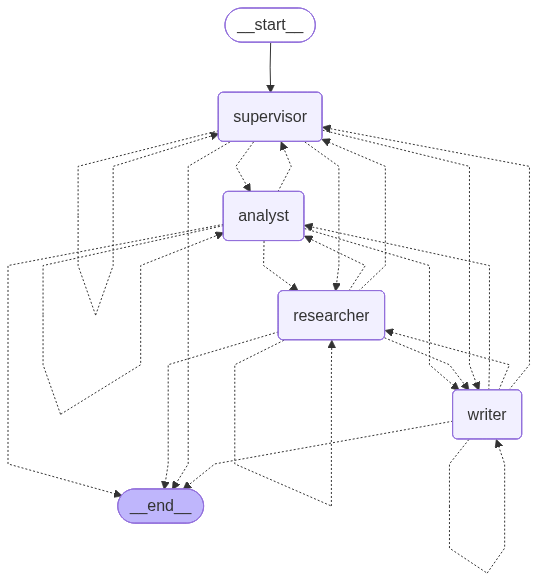

In [45]:
graph

In [46]:
response=graph.invoke(HumanMessage(content="What are the benefits and risks of AI in healthcare?"))

researcher
analyst
writer


In [47]:
response

{'messages': [AIMessage(content="📋 Supervisor: Let's start with research. Assigning to Researcher...", additional_kwargs={}, response_metadata={}, id='5d28c7da-ab0f-4e43-a71c-c0d983c85783'),
  AIMessage(content="🔍 Researcher: I've completed the research on 'No task'.\n\nKey findings:\nSince no specific task was provided, I'll give a general example of what the response could look like for a hypothetical task.\n\n**Task:** Research on the Impact of Climate Change on Coastal Ecosystems\n\n### 1. Key Facts and Background\n\n- **Definition:** Coastal ecosystems refer to the diverse range of marine and terrestrial habitats found along coastlines, including mangroves, coral reefs, salt marshes, and dunes.\n- **Climate Change Impact:** Rising sea levels, increased storm frequency, and alte...", additional_kwargs={}, response_metadata={}, id='bb6c6b8c-0c6d-4bdc-9cfb-20c3e583a8e9'),
  AIMessage(content='📋 Supervisor: Research done. Time for analysis. Assigning to Analyst...', additional_kwargs=

In [51]:
response['final_report']

"\n📄 FINAL REPORT\n==================================================\nGenerated: 2025-10-23 16:47\nTopic: 📊 Analyst: I've completed the analysis.\n\nTop insights:\n### Analysis of Hypothetical Research Task: 'No task'\n\nGiven the lack of a specific task, I will provide a general analysis of the hypothetical task: 'Research on the Impact of Climate Change on Coastal Ecosystems.'\n\n### 1. Key Insights and Patterns\n\n* **Rising Sea Levels and Storms:** The data highlights a significant increase in sea levels (20 cm since 1880) and a corresponding rise in storm fre...\n==================================================\n\n**Executive Report: Research on the Impact of Climate Change on Coastal Ecosystems**\n\n**[Date: 23 October 2025]**\n\n**[Company: Sustainable Research Institute]**\n\n**[Author: [Your Name]]**\n\n**Executive Summary**\n\nThis report presents the findings of a hypothetical research task on the impact of climate change on coastal ecosystems. The analysis reveals signif